In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [96]:
path = '../Dataset/bank_customer.csv'
df = pd.read_csv(path)

In [97]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


In [98]:
#mapping the Account_Category	
category_mapping = {
    'X1': 'Savings Account',
    'X2': 'Current Account',
    'X3': 'Senior Citizens Account',
    'X4': 'Investment Account'
}

# Replace the values in the Account_Category column
df['Account_Category'] = df['Account_Category'].replace(category_mapping)

In [99]:
df.duplicated().sum()

0

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [101]:
missing_values = df.isna().sum().to_dict()

# Filter columns with missing values
columns_with_missing_values = {k: v for k, v in missing_values.items() if v > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] in ['int64', 'float64']}
categorical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] == 'object'}

print("Numerical columns with missing values:", numerical_missing)
print("Categorical columns with missing values:", categorical_missing)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


In [102]:
from sklearn.impute import KNNImputer
import pandas as pd

df_copy = df.copy()

numerical_columns = ['Month_Income']  
categorical_columns = ['Occupation', 'Loan_Status']  

imputer = KNNImputer(n_neighbors=5)
df[numerical_columns] = imputer.fit_transform(df_copy[numerical_columns])

for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

print(df.isnull().sum())



Unnamed: 0               0
ID                       0
Gender                   0
Month_Income             0
Age                      0
Region_Code              0
Occupation               0
Credit_Score             0
Loan_Status              0
Existing_Credit_Cards    0
Avg_Account_Balance      0
Account_Category         0
Tenure_with_Bank         0
Lead_Outcome             0
dtype: int64


C:\Users\Gen\AppData\Local\Temp\ipykernel_3776\3595242242.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [103]:
df = df.drop(['Unnamed: 0','ID','Region_Code'], axis=1)

In [104]:
df.head()

,Gender,Month_Income,Age,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,Male,96345.0,29,Other,623,Yes,4,742366,Savings Account,2,No
1,Male,85640.0,43,Other,629,No,0,925537,Current Account,1,No
2,Male,96345.0,31,Salaried,357,No,0,215949,Savings Account,1,No
3,Male,85640.0,29,Other,356,No,0,868070,Savings Account,3,No
4,Female,42820.0,29,Other,572,No,0,657087,Savings Account,3,No


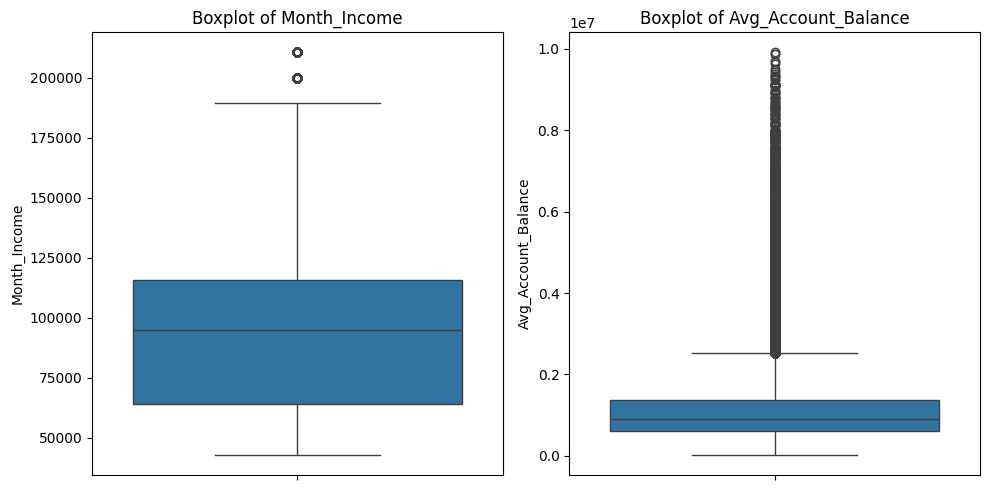

In [105]:
columns_with_outliers = ['Month_Income', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [106]:
def remove_outliers_zscore(df, threshold=3):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        z_scores = (df_cleaned[column] - df_cleaned[column].mean()) / df_cleaned[column].std()
        
        outliers_condition = np.abs(z_scores) > threshold
        
        df_cleaned = df_cleaned[outliers_condition]
        
        print(f"Column: {column}")
        print(f"Removed {outliers_condition.sum()} outliers.")
        print("*" * 40)
        
    return df_cleaned

df_new = remove_outliers_zscore(df)


Column: Month_Income
Removed 0 outliers.
****************************************
Column: Age
Removed 0 outliers.
****************************************
Column: Credit_Score
Removed 0 outliers.
****************************************
Column: Existing_Credit_Cards
Removed 0 outliers.
****************************************
Column: Avg_Account_Balance
Removed 0 outliers.
****************************************
Column: Tenure_with_Bank
Removed 0 outliers.
****************************************


In [107]:
#selecting categorical columns

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols

['Gender', 'Occupation', 'Loan_Status', 'Account_Category', 'Lead_Outcome']

In [108]:
#selecting numerical columns

numerical_cols = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_cols

['Month_Income',
 'Age',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [109]:
for column in categorical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

        Count  Percentage
Gender                   
Male    57546   54.805714
Female  47454   45.194286
----------------------------------------
               Count  Percentage
Occupation                      
Self_Employed  44541   42.420000
Salaried       30066   28.634286
Other          29343   27.945714
Entrepreneur    1050    1.000000
----------------------------------------
             Count  Percentage
Loan_Status                   
No           73920        70.4
Yes          31080        29.6
----------------------------------------
                         Count  Percentage
Account_Category                          
Savings Account          44338   42.226667
Senior Citizens Account  29191   27.800952
Current Account          29097   27.711429
Investment Account        2374    2.260952
----------------------------------------
              Count  Percentage
Lead_Outcome                   
No            63605    60.57619
Yes           41395    39.42381
------------------------

In [110]:
for column in numerical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

               Count  Percentage
Month_Income                    
85640.000000    8938    8.512381
42820.000000    8934    8.508571
107050.000000   8916    8.491429
74935.000000    8897    8.473333
64230.000000    8824    8.403810
96345.000000    8806    8.386667
53525.000000    8773    8.355238
210500.000000   2960    2.819048
199975.000000   2944    2.803810
136825.000000   2931    2.791429
147350.000000   2930    2.790476
126300.000000   2929    2.789524
105250.000000   2903    2.764762
189450.000000   2899    2.760952
168400.000000   2890    2.752381
94725.000000    2862    2.725714
115775.000000   2858    2.721905
84200.000000    2843    2.707619
157875.000000   2840    2.704762
73675.000000    2830    2.695238
178925.000000   2807    2.673333
101550.327858   2486    2.367619
----------------------------------------
     Count  Percentage
Age                   
28    6324    6.022857
29    5683    5.412381
27    5585    5.319048
30    4601    4.381905
26    3865    3.680952
..    

In [111]:
def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <10:
        return '5-10'
    elif value >= 10:
        return '10+'

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

df['Tenure_with_Bank'] = df['Tenure_with_Bank'].replace({'5-10': 10, '10+': 15})

print(df['Tenure_with_Bank'].value_counts())



Tenure_with_Bank
10    31506
15    22530
2     12796
1     12754
3     12747
4     12667
Name: count, dtype: int64


C:\Users\Gen\AppData\Local\Temp\ipykernel_3776\2923662720.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Tenure_with_Bank'] = df['Tenure_with_Bank'].replace({'5-10': 10, '10+': 15})


Value counts before undersampling:
Existing_Credit_Cards
0    73920
1    31080
Name: count, dtype: int64


C:\Users\Gen\AppData\Local\Temp\ipykernel_3776\2567631106.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_resampled.index, y=value_counts_resampled.values, palette='viridis')


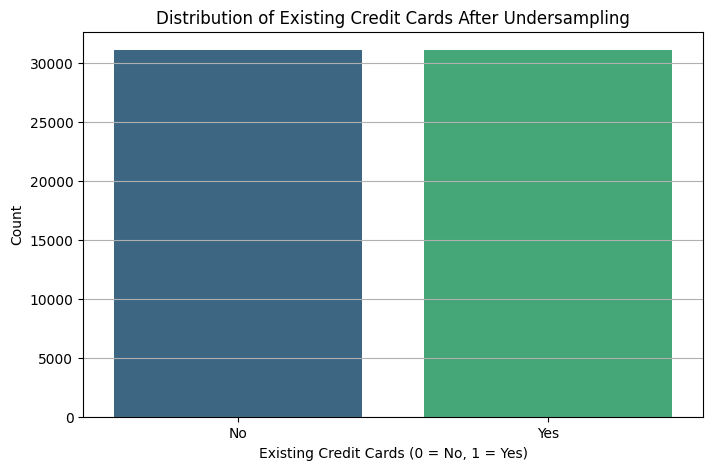

In [112]:

from imblearn.under_sampling import RandomUnderSampler

# Handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

# Print the value counts before undersampling
print("Value counts before undersampling:")
print(df['Existing_Credit_Cards'].value_counts())

# Prepare data for undersampling
X = df.drop(columns='Existing_Credit_Cards')  
y = df['Existing_Credit_Cards']                

# Undersample the majority class
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine the resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Existing_Credit_Cards'] = y_resampled

# Get the value counts after undersampling
value_counts_resampled = df_resampled['Existing_Credit_Cards'].value_counts()

# Plotting the distribution after undersampling
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts_resampled.index, y=value_counts_resampled.values, palette='viridis')
plt.title('Distribution of Existing Credit Cards After Undersampling')
plt.xlabel('Existing Credit Cards (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=value_counts_resampled.index, labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()


In [113]:
import pandas as pd

print("Original value counts:")
print(df['Occupation'].value_counts())

# Combine 'Entrepreneur' with 'Other'
df['Occupation'] = df['Occupation'].replace({'Entrepreneur': 'Other'})

# Display updated value counts to verify the change
print("\nUpdated value counts after combining 'Entrepreneur' with 'Other':")
print(df['Occupation'].value_counts())


Original value counts:
Occupation
Self_Employed    44541
Salaried         30066
Other            29343
Entrepreneur      1050
Name: count, dtype: int64

Updated value counts after combining 'Entrepreneur' with 'Other':
Occupation
Self_Employed    44541
Other            30393
Salaried         30066
Name: count, dtype: int64


In [114]:
print("\nStatistical summary of the dataset")
df.describe()


Statistical summary of the dataset


,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank
count,105000.000000,105000.000000,105000.000000,105000.000000,1.050000e+05,105000.000000
mean,101550.327858,43.875381,602.642581,0.296000,1.134120e+06,7.431095
std,44996.550975,14.873280,180.611716,0.456493,8.663714e+05,5.166731
min,42820.000000,24.000000,300.000000,0.000000,2.259700e+04,1.000000
25%,64230.000000,30.000000,444.000000,0.000000,6.039600e+05,3.000000
50%,94725.000000,43.000000,590.000000,0.000000,8.964700e+05,10.000000
75%,115775.000000,54.000000,771.000000,1.000000,1.371552e+06,10.000000
max,210500.000000,85.000000,900.000000,1.000000,9.908858e+06,15.000000


In [115]:
print(df.columns)

Index(['Gender', 'Month_Income', 'Age', 'Occupation', 'Credit_Score',
       'Loan_Status', 'Existing_Credit_Cards', 'Avg_Account_Balance',
       'Account_Category', 'Tenure_with_Bank', 'Lead_Outcome'],
      dtype='object')


In [116]:
df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 


In [117]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender','Occupation', 'Loan_Status', 'Account_Category']

encoder = OneHotEncoder( sparse_output=False)  

encoded_columns = encoder.fit_transform(df[categorical_columns])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

df_final = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

print(df_final.head())




   Month_Income  Age  Credit_Score  Existing_Credit_Cards  \
0       96345.0   29           623                      1   
1       85640.0   43           629                      0   
2       96345.0   31           357                      0   
3       85640.0   29           356                      0   
4       42820.0   29           572                      0   

   Avg_Account_Balance  Tenure_with_Bank  Lead_Outcome  Gender_Female  \
0               742366                 2             0            0.0   
1               925537                 1             0            0.0   
2               215949                 1             0            0.0   
3               868070                 3             0            0.0   
4               657087                 3             0            1.0   

   Gender_Male  Occupation_Other  Occupation_Salaried  \
0          1.0               1.0                  0.0   
1          1.0               1.0                  0.0   
2          1.0         

In [118]:
df_final.head()

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank,Lead_Outcome,Gender_Female,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Loan_Status_No,Loan_Status_Yes,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account
0,96345.0,29,623,1,742366,2,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,85640.0,43,629,0,925537,1,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,96345.0,31,357,0,215949,1,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,85640.0,29,356,0,868070,3,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,42820.0,29,572,0,657087,3,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [119]:
print("Missing values in df_final:", pd.isnull(df_final).sum())


Missing values in df_final: Month_Income                                0
Age                                         0
Credit_Score                                0
Existing_Credit_Cards                       0
Avg_Account_Balance                         0
Tenure_with_Bank                            0
Lead_Outcome                                0
Gender_Female                               0
Gender_Male                                 0
Occupation_Other                            0
Occupation_Salaried                         0
Occupation_Self_Employed                    0
Loan_Status_No                              0
Loan_Status_Yes                             0
Account_Category_Current Account            0
Account_Category_Investment Account         0
Account_Category_Savings Account            0
Account_Category_Senior Citizens Account    0
dtype: int64


In [121]:
print(df_final.isnull().sum())


Month_Income                                0
Age                                         0
Credit_Score                                0
Existing_Credit_Cards                       0
Avg_Account_Balance                         0
Tenure_with_Bank                            0
Lead_Outcome                                0
Gender_Female                               0
Gender_Male                                 0
Occupation_Other                            0
Occupation_Salaried                         0
Occupation_Self_Employed                    0
Loan_Status_No                              0
Loan_Status_Yes                             0
Account_Category_Current Account            0
Account_Category_Investment Account         0
Account_Category_Savings Account            0
Account_Category_Senior Citizens Account    0
dtype: int64


In [122]:
X = df_final.drop('Lead_Outcome', axis=1)
y = df_final['Lead_Outcome']

In [123]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [124]:
#check each model accuracy one by one
def model_acc(model):
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(str(model)+ ' --> ' +str(acc))

In [125]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


LogisticRegression() --> 0.8403809523809523
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86     19081
           1       0.76      0.86      0.81     12419

    accuracy                           0.84     31500
   macro avg       0.83      0.84      0.84     31500
weighted avg       0.85      0.84      0.84     31500



c:\Users\Gen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


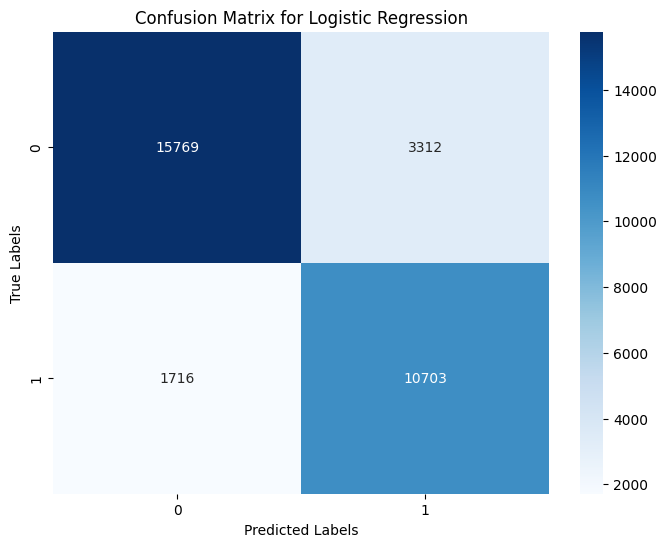

In [126]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
model_acc(log)

# Predict on test set
y_pred = log.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

KNeighborsClassifier() --> 0.939047619047619
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     19081
           1       0.96      0.88      0.92     12419

    accuracy                           0.94     31500
   macro avg       0.94      0.93      0.94     31500
weighted avg       0.94      0.94      0.94     31500



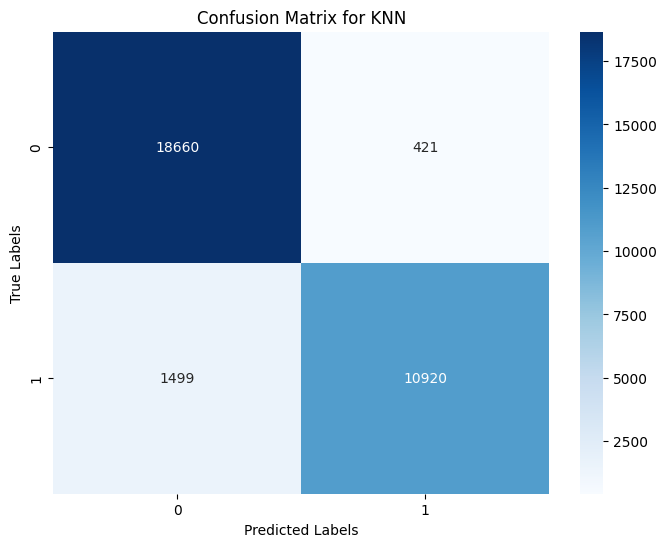

In [127]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier()
model_acc(kn)

# Predict on test set
y_pred = kn.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



SVC() --> 0.871904761904762
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90     19081
           1       1.00      0.68      0.81     12419

    accuracy                           0.87     31500
   macro avg       0.91      0.84      0.86     31500
weighted avg       0.89      0.87      0.87     31500



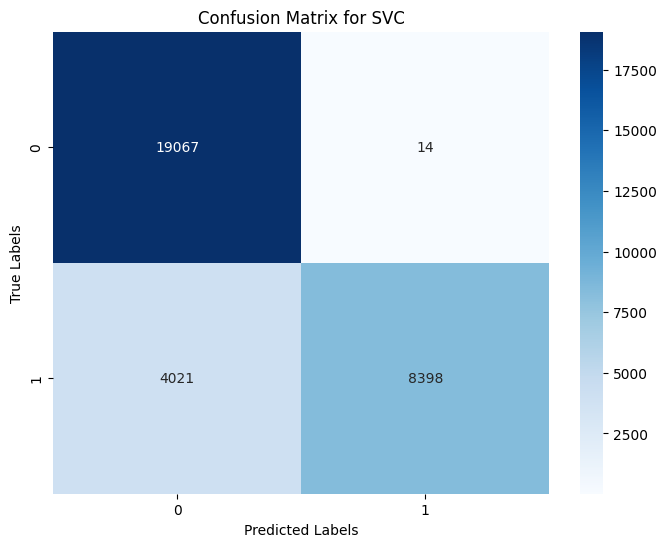

In [128]:
from sklearn.svm import SVC
svc_m = SVC()
model_acc(svc_m)

# Predict on test set
y_pred = svc_m.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
 
 

MLPClassifier() --> 0.5898412698412698
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.33      0.49     19081
           1       0.49      0.99      0.66     12419

    accuracy                           0.59     31500
   macro avg       0.74      0.66      0.57     31500
weighted avg       0.79      0.59      0.56     31500



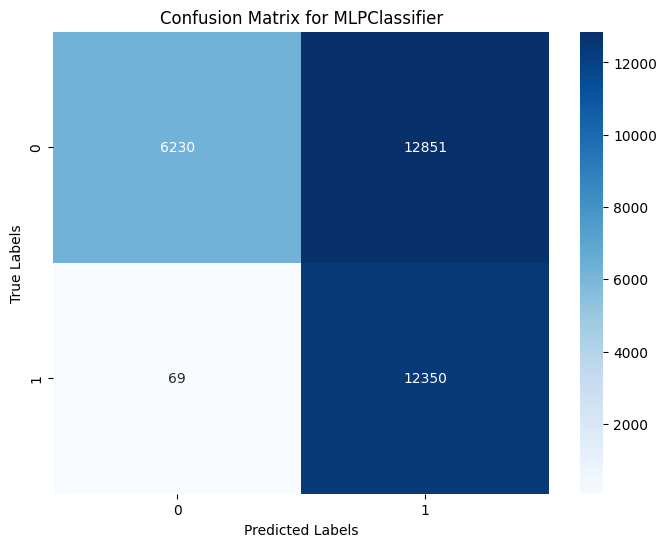

In [129]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
model_acc(mlp)

# Predict on test set
y_pred = mlp.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for MLPClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [130]:
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [10, 20, 30]  
}


# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [ 0.001, 0.01],  
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300]
}



# Initialize models
models = {
    'KNN': (KNeighborsClassifier(), param_grid_knn, GridSearchCV),
    'Logistic Regression': (LogisticRegression(class_weight='balanced'), param_grid_lr, GridSearchCV),
    'MLPClassifier': (MLPClassifier(), param_grid_mlp, RandomizedSearchCV)

    
}

In [131]:
# Perform hyperparameter tuning with K-Fold Cross Validation
best_models = {}

for name, (model, param_grid, search_method) in models.items():
    print("-" * 100)
    print(f"Starting hyperparameter tuning for {name}...")
    
    # For GridSearchCV or RandomizedSearchCV based on the model
    if search_method == GridSearchCV:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)
    else:
        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=kfold, n_jobs=-1, verbose=2, random_state=42)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    print("-" * 100)
    
    best_models[name] = grid_search.best_estimator_

----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for KNN...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for KNN: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.9564353741496598
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Gen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.8348979591836734
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for MLPClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for MLPClassifier: {'solver': 'adam', 'max_iter': 300, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'relu'}
Best score for MLPClassifier: 0.9038911564625851
----------------------------------------------------------------------------------------------------


In [132]:
# Evaluate the tuned models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        print(f'\nPerformance Report for {name} (Tuned):\n')
        
        # Predict the outcomes
        y_pred = model.predict(X_test)
        
        # Compute and print accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # Compute and print classification report
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

# Call the function to evaluate the best models
evaluate_models(best_models, X_test, y_test)


Performance Report for KNN (Tuned):

Accuracy: 0.9616
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     19081
           1       0.97      0.94      0.95     12419

    accuracy                           0.96     31500
   macro avg       0.96      0.96      0.96     31500
weighted avg       0.96      0.96      0.96     31500


Performance Report for Logistic Regression (Tuned):

Accuracy: 0.7138
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     19081
           1       0.60      0.84      0.70     12419

    accuracy                           0.71     31500
   macro avg       0.73      0.74      0.71     31500
weighted avg       0.76      0.71      0.72     31500


Performance Report for MLPClassifier (Tuned):

Accuracy: 0.9977
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.

In [133]:
predicted = kn.predict(X_test)

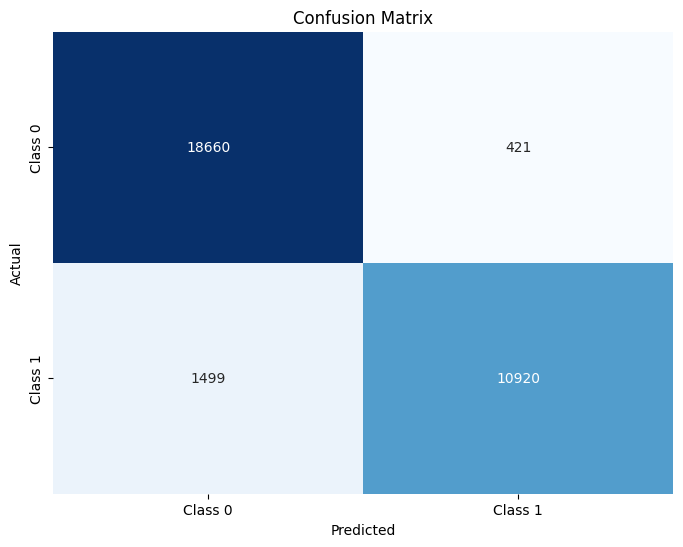

In [134]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

labels = ['Class 0', 'Class 1']  
plot_confusion_matrix(cm, labels)


In [135]:
# import joblib

# # Save the mode
# joblib.dump(best_models['KNN'], '../TrainedModels/KNN_model.pkl')

In [136]:
# df_final.to_csv('training_dataset.csv', index=False)


In [137]:
import joblib

# Load your trained model (ensure you have saved your model as 'model.pkl' using joblib or pickle)
model = joblib.load('../TrainedModels/KNN_model.pkl')

In [138]:
import pandas as pd
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Month_Income': [200000],
    'Age': [35],
    'Occupation': ['Other'],
    'Credit_Score': [350],
    'Loan_Status': ['No'],
    'Existing_Credit_Cards': [2],
    'Avg_Account_Balance': [100000],
    'Account_Category': ['Investment Account'],
    'Tenure_with_Bank': [1]
})

In [139]:
new_data_encoded = pd.get_dummies(new_data)

# Ensure that the new_data has all the columns that the model was trained on
missing_cols = set(X_train.columns) - set(new_data_encoded.columns)
for col in missing_cols:
    new_data_encoded[col] = 0

# Reorder the columns to match the training data
new_data_encoded = new_data_encoded[X_train.columns]

# Now, make predictions
predictions = model.predict(new_data_encoded)

# Convert numeric predictions (1/0) to 'Yes'/'No'
predictions = ['Yes' if pred == 1 else 'No' for pred in predictions]

print(f'Predicted Lead Outcome: {predictions[0]}')

Predicted Lead Outcome: Yes
